In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install py_vncorenlp

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.7 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4304 sha256=480a6a6e053987abe28663269e735310eda39644fe61b2abe5ec6e0fbc13baf2
  Stored in directory: /root/.cache/pip/wheels/6d/2d/d6/158260bfd6820d144535857b80cc112bee5c3aa6d81b6dc049
Successfully built py_vncorenlp


In [3]:
import py_vncorenlp
import os

# Define the save directory
save_dir = '/content/vncorenlp'

# Create the save directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Download the model
py_vncorenlp.download_model(save_dir=save_dir)

# Load the word and sentence segmentation component
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=save_dir)

In [4]:
text = "Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây."

output = rdrsegmenter.word_segment(text)


In [5]:
import re
def remove_emoji(text):
    # Sử dụng biểu thức chính quy để loại bỏ emoji
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"  # Mặt cười
        "\U0001F300-\U0001F5FF"  # Ký hiệu & biểu tượng
        "\U0001F680-\U0001F6FF"  # Giao thông & biển báo
        "\U0001F700-\U0001F77F"  # Các biểu tượng khác
        "\U0001F780-\U0001F7FF"  # Các biểu tượng bổ sung
        "\U0001F800-\U0001F8FF"  # Các ký hiệu bổ sung
        "\U0001F900-\U0001F9FF"  # Biểu tượng bổ sung (ví dụ: tay, khuôn mặt)
        "\U0001FA00-\U0001FA6F"  # Biểu tượng bổ sung mới
        "\U0001FA70-\U0001FAFF"  # Biểu tượng bổ sung mới
        "\U00002702-\U000027B0"  # Ký hiệu bổ sung
        "\U000024C2-\U0001F251"  # Ký tự đặc biệt
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(" ", text)

def preprocess_text(text):
    # Chuẩn hóa Unicode (NFC)

    # Loại bỏ emoji
    text = remove_emoji(text)

    # Loại bỏ các ký tự không phải chữ cái, số và khoảng trắng (bao gồm cả tiếng Việt)
    text = re.sub(r"[^a-zA-Z0-9À-ỹà-ỹ\s]", " ", text)

    # Chuyển văn bản về chữ thường
    text = text.lower()

    # Loại bỏ khoảng trắng thừa
    text = re.sub(r"\s+", " ", text).strip()
    text = rdrsegmenter.word_segment(text)
    return "".join(text)

In [6]:
output

['Ông Nguyễn_Khắc_Chúc đang làm_việc tại Đại_học Quốc_gia Hà_Nội .',
 'Bà Lan , vợ ông Chúc , cũng làm_việc tại đây .']

In [8]:
import pandas as pd

df_dev = pd.read_parquet("/content/dev-00000-of-00001.parquet")
df_test = pd.read_parquet("/content/test-00000-of-00001.parquet")
df_train = pd.read_parquet("/content/train-00000-of-00001.parquet")


In [9]:
df_train['Statement'] = df_train['Statement'].apply(preprocess_text)
df_train['Evidence'] = df_train['Evidence'].apply(preprocess_text)
df_dev['Statement'] = df_dev['Statement'].apply(preprocess_text)
df_dev['Evidence'] = df_dev['Evidence'].apply(preprocess_text)
df_test['Statement'] = df_test['Statement'].apply(preprocess_text)
df_test['Evidence'] = df_test['Evidence'].apply(preprocess_text)

In [10]:
len(df_dev), len(df_test), len(df_train)

(723, 1447, 5062)

In [11]:

df_dev.head(3)

,Unnamed: 0,index,Statement,Context,annotation_id,Topic,Author,Url,labels,Evidence
0,0,6040,vào tháng 4 1930 tl nhà_vua na_uy harald v vua...,"Saigon Morin, khách sạn 4 sao hàng đầu tại Huế...",18220511,Du lịch,Thanh Niên,https://thanhnien.vn/khach-san-lau-doi-nhat-co...,1,vua hề charlie chaplin vua hề_sác lô và vợ từn...
1,1,5599,nhiều chi_bộ chỉ mua báo đảng mà không quan_tâ...,"(Chinhphu.vn) - Bí thư Trung ương Đảng, Trưởng...",18537674,Chính trị,Chính Phủ,https://baochinhphu.vn/phat-huy-gia-tri-bao-ta...,1,việc mua đọc sử_dụng báo tạp_chí của đảng tại ...
2,2,1947,công_ty tnhh mua_bán nợ dsp địa_chỉ 91 pasteur...,(NLĐO)- Sau khi mua khoản nợ từ Công ty Mirae ...,19570487,Pháp luật,Người lao động,https://nld.com.vn/phap-luat/cong-ty-o-tp-hcm-...,1,công_ty tnhh mua_bán nợ dsp địa_chỉ tầng 4 chu...


In [12]:
import warnings
import logging
import torch
import pandas as pd
import ast
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import classification_report
import transformers

In [13]:
class SentencePairDataset(Dataset):
    def __init__(self, sentence_pairs, labels, tokenizer, max_length):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentence_pairs)

    def __getitem__(self, idx):
        sentence1, sentence2 = self.sentence_pairs[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            sentence1,
            text_pair=sentence2,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True,
            return_overflowing_tokens=False
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }


In [14]:
class PhoBERTClassifier(nn.Module):
    def __init__(self, phobert, num_classes):
        super(PhoBERTClassifier, self).__init__()
        self.phobert = phobert
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(self.phobert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.phobert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False,
        )
        dropout_output = self.dropout(pooled_output)
        logits = self.linear(dropout_output)
        return logits

In [15]:
def prepare_dataset(data):
    statements = list(data["Statement"])
    evidences = list(data["Evidence"])

    return [(s, e) for s, e in zip(statements, evidences)]

In [16]:
X_train = prepare_dataset(df_train)
X_test = prepare_dataset(df_test)
X_dev = prepare_dataset(df_dev)

In [17]:
y_train = list(df_train["labels"])
y_test = list(df_test["labels"])
y_dev = list(df_dev["labels"])


In [23]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
phobert = AutoModel.from_pretrained("vinai/phobert-base")
max_length = 256

In [24]:
train_dataset = SentencePairDataset(X_train, y_train, tokenizer, max_length)
dev_dataset = SentencePairDataset(X_dev, y_dev, tokenizer, max_length)
test_dataset = SentencePairDataset(X_test, y_test, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=16,num_workers=8,shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16,num_workers=8,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16,num_workers=8,shuffle=False)


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PhoBERTClassifier(phobert, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-5,
)


In [26]:
import torch
import torch.nn as nn
import torch.amp
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
def train_model_text_classification(model, train_loader, val_loader, criterion, optimizer,
                                    num_epochs=10, device='cuda', early_stop_patience=3,
                                    model_save_path='/content/drive/MyDrive/bao/model_pho_bert_base.pth', metric_to_monitor='acc'):

    best_val_metric = -float('inf')
    early_stop_counter = 0
    best_epoch = 0

    model.to(device)
    # Lưu lịch sử để vẽ đồ thị
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1s, val_f1s = [], []

    for epoch in range(num_epochs):
        running_loss = 0.0
        all_preds, all_labels = [], []

        train_pbar = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training", leave=False)
        for batch in train_pbar:
            model.train()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1s.append(train_f1)

        # Validation
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc="[Validation]", leave=False)
            for batch in val_pbar:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)


        print(f"\n📊 Epoch {epoch+1}/{num_epochs}")
        print(f"--- Train ---     Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}% | F1: {train_f1:.4f}")
        print(f"--- Validation --- Loss: {val_loss:.4f} | Acc: {val_acc*100:.2f}% | F1: {val_f1:.4f}")

        current_val_metric = val_f1 if metric_to_monitor == 'f1' else val_acc

        if current_val_metric > best_val_metric:
            best_val_metric = current_val_metric
            best_epoch = epoch
            early_stop_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f"✅ Model improved & saved to {model_save_path}")
        else:
            early_stop_counter += 1
            print(f"⏳ Early Stop Counter: {early_stop_counter}/{early_stop_patience}")

        if early_stop_counter >= early_stop_patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch+1}. Best epoch: {best_epoch+1}")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s


In [27]:
train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s = train_model_text_classification(
    model,
    train_loader,
    dev_loader,
    criterion,
    optimizer,
    num_epochs=15,
    early_stop_patience=7,
    metric_to_monitor='acc'
)


[Epoch 1/15] Training:  66%|██████▌   | 210/317 [01:06<00:34,  3.12it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 1/15
--- Train ---     Loss: 0.9960 | Acc: 48.54% | F1: 0.4767
--- Validation --- Loss: 0.7981 | Acc: 66.25% | F1: 0.6460
✅ Model improved & saved to /content/drive/MyDrive/bao/model_pho_bert_base.pth


[Epoch 2/15] Training:  17%|█▋        | 55/317 [00:17<01:22,  3.17it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 2/15
--- Train ---     Loss: 0.5996 | Acc: 76.02% | F1: 0.7573
--- Validation --- Loss: 0.6464 | Acc: 75.66% | F1: 0.7590
✅ Model improved & saved to /content/drive/MyDrive/bao/model_pho_bert_base.pth


[Epoch 3/15] Training:  77%|███████▋  | 243/317 [01:18<00:23,  3.11it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 3/15
--- Train ---     Loss: 0.4412 | Acc: 83.74% | F1: 0.8367
--- Validation --- Loss: 0.6201 | Acc: 78.56% | F1: 0.7841
✅ Model improved & saved to /content/drive/MyDrive/bao/model_pho_bert_base.pth


[Epoch 4/15] Training:  29%|██▊       | 91/317 [00:29<01:12,  3.12it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 4/15
--- Train ---     Loss: 0.3337 | Acc: 87.97% | F1: 0.8794
--- Validation --- Loss: 0.5670 | Acc: 80.08% | F1: 0.7990
✅ Model improved & saved to /content/drive/MyDrive/bao/model_pho_bert_base.pth


[Epoch 5/15] Training:  73%|███████▎  | 230/317 [01:13<00:27,  3.13it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 5/15
--- Train ---     Loss: 0.2604 | Acc: 90.97% | F1: 0.9096
--- Validation --- Loss: 0.5961 | Acc: 80.22% | F1: 0.8027
✅ Model improved & saved to /content/drive/MyDrive/bao/model_pho_bert_base.pth


[Epoch 6/15] Training:  53%|█████▎    | 168/317 [00:54<00:47,  3.13it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 6/15
--- Train ---     Loss: 0.1990 | Acc: 93.36% | F1: 0.9337
--- Validation --- Loss: 0.6572 | Acc: 80.77% | F1: 0.8092
✅ Model improved & saved to /content/drive/MyDrive/bao/model_pho_bert_base.pth


[Epoch 7/15] Training:  29%|██▊       | 91/317 [00:29<01:12,  3.12it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 7/15
--- Train ---     Loss: 0.1492 | Acc: 95.08% | F1: 0.9508
--- Validation --- Loss: 0.6619 | Acc: 81.19% | F1: 0.8122
✅ Model improved & saved to /content/drive/MyDrive/bao/model_pho_bert_base.pth


[Epoch 8/15] Training:  36%|███▋      | 115/317 [00:37<01:04,  3.12it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 8/15
--- Train ---     Loss: 0.1063 | Acc: 96.66% | F1: 0.9666
--- Validation --- Loss: 0.7309 | Acc: 80.64% | F1: 0.8070
⏳ Early Stop Counter: 1/7


[Epoch 9/15] Training:  66%|██████▌   | 210/317 [01:07<00:34,  3.12it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 9/15
--- Train ---     Loss: 0.0861 | Acc: 97.35% | F1: 0.9735
--- Validation --- Loss: 0.8062 | Acc: 80.50% | F1: 0.8056
⏳ Early Stop Counter: 2/7


[Epoch 10/15] Training:   0%|          | 0/317 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 10/15
--- Train ---     Loss: 0.0773 | Acc: 97.77% | F1: 0.9777
--- Validation --- Loss: 0.8045 | Acc: 81.88% | F1: 0.8191
✅ Model improved & saved to /content/drive/MyDrive/bao/model_pho_bert_base.pth


[Epoch 11/15] Training:  36%|███▌      | 113/317 [00:36<01:04,  3.14it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 11/15
--- Train ---     Loss: 0.0736 | Acc: 97.63% | F1: 0.9763
--- Validation --- Loss: 0.7605 | Acc: 81.33% | F1: 0.8132
⏳ Early Stop Counter: 1/7


[Epoch 12/15] Training:  22%|██▏       | 69/317 [00:22<01:19,  3.13it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 12/15
--- Train ---     Loss: 0.0554 | Acc: 98.14% | F1: 0.9814
--- Validation --- Loss: 0.8032 | Acc: 82.16% | F1: 0.8210
✅ Model improved & saved to /content/drive/MyDrive/bao/model_pho_bert_base.pth


[Epoch 13/15] Training:   0%|          | 0/317 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 13/15
--- Train ---     Loss: 0.0400 | Acc: 98.83% | F1: 0.9884
--- Validation --- Loss: 0.8142 | Acc: 82.85% | F1: 0.8288
✅ Model improved & saved to /content/drive/MyDrive/bao/model_pho_bert_base.pth


[Epoch 14/15] Training:  62%|██████▏   | 195/317 [01:02<00:39,  3.13it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 14/15
--- Train ---     Loss: 0.0395 | Acc: 98.66% | F1: 0.9866
--- Validation --- Loss: 0.9150 | Acc: 81.60% | F1: 0.8145
⏳ Early Stop Counter: 1/7


[Epoch 15/15] Training:  78%|███████▊  | 247/317 [01:19<00:22,  3.13it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
                                                             


📊 Epoch 15/15
--- Train ---     Loss: 0.0284 | Acc: 99.09% | F1: 0.9909
--- Validation --- Loss: 0.9522 | Acc: 80.50% | F1: 0.8057
⏳ Early Stop Counter: 2/7


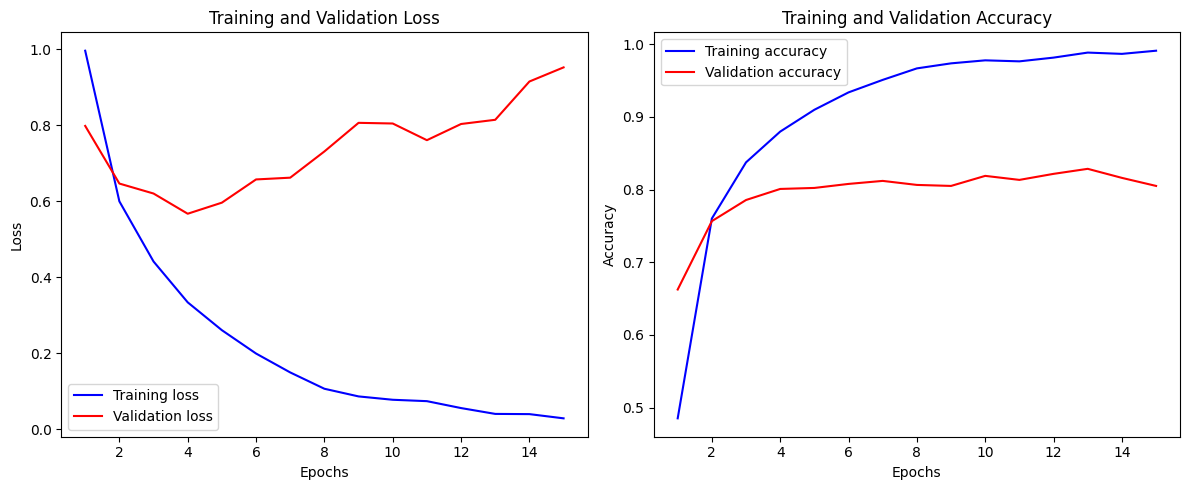

In [28]:
import matplotlib.pyplot as plt
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [29]:
def test_model_text_classification(model, test_loader, model_path,
                                   device='cuda', return_preds=False):
    import numpy as np
    from sklearn.metrics import accuracy_score, f1_score, classification_report

    # Load model đã huấn luyện
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc="[Testing]", leave=False)
        for batch in test_pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print("\n📊 Test Results:")
    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"F1-score: {f1:.4f}")
    print("\nDetailed Report:\n", classification_report(all_labels, all_preds, zero_division=0))

    if return_preds:
        return all_labels, all_preds
    else:
        return acc, f1


In [30]:
test_model_text_classification(model, test_loader, model_path="/content/drive/MyDrive/bao/model_pho_bert_base.pth")

[Testing]:  67%|██████▋   | 61/91 [00:06<00:03,  9.72it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
                                                          


📊 Test Results:
Accuracy: 84.17%
F1-score: 0.8422

Detailed Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       508
           1       0.80      0.83      0.82       468
           2       0.92      0.82      0.87       471

    accuracy                           0.84      1447
   macro avg       0.85      0.84      0.84      1447
weighted avg       0.85      0.84      0.84      1447



(0.8417415342087077, 0.8421607510105044)